In [2]:
'''Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import numpy as np
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [3]:
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# Converting the image to B/W
x_train[x_train < 127] = 0
x_train[x_train >= 127] = 1
x_test[x_test < 127] = 0
x_test[x_test >= 127] = 1

# For the greyscale images
# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# x_train /= 255
# x_test /= 255

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [4]:
# Training the model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 23s - loss: 0.3439 - acc: 0.8955 - val_loss: 0.0845 - val_acc: 0.9741
Epoch 2/12
60000/60000 [==============================] - 17s - loss: 0.1235 - acc: 0.9639 - val_loss: 0.0568 - val_acc: 0.9807
Epoch 3/12
60000/60000 [==============================] - 17s - loss: 0.0921 - acc: 0.9724 - val_loss: 0.0471 - val_acc: 0.9838
Epoch 4/12
60000/60000 [==============================] - 17s - loss: 0.0776 - acc: 0.9768 - val_loss: 0.0428 - val_acc: 0.9850
Epoch 5/12
60000/60000 [==============================] - 17s - loss: 0.0668 - acc: 0.9804 - val_loss: 0.0427 - val_acc: 0.9855
Epoch 6/12
60000/60000 [==============================] - 17s - loss: 0.0596 - acc: 0.9826 - val_loss: 0.0379 - val_acc: 0.9869
Epoch 7/12
60000/60000 [==============================] - 17s - loss: 0.0543 - acc: 0.9839 - val_loss: 0.0358 - val_acc: 0.9875
Epoch 8/12
60000/60000 [==============================

In [5]:
def mutation_manager(data, indices):
    rows = data.shape[0]
    cols = data.shape[1]
        
    for x in indices:
        row_no = int(x/cols)
        col_no = x % cols
        
        if data[row_no,col_no] == 1:
            data[row_no,col_no] = 0
        else:
            data[row_no,col_no] = 1
    return data

In [6]:
def crossover_manager(genome1, genome2):
    new1 = []
    new2 = []
    random_index_to_cut = int(np.random.random() * len(genome1))
    new1 = list(genome1[:random_index_to_cut]) + list(genome2[random_index_to_cut:])
    new2 = list(genome2[:random_index_to_cut]) + list(genome1[random_index_to_cut:])
    
    return np.array(new1), np.array(new2)

In [7]:
def genetic_op(data, required_val, mutation_rate, crossover_rate):
    # Crossover operation
    no_of_crossovers = int(data.shape[0] * crossover_rate)
    indices_to_crossover = np.random.choice(data.shape[0],no_of_crossovers, replace=False)
    data_to_be_crossover = data[indices_to_crossover]
    
    for x in range(0,len(indices_to_crossover) - 1, 2):
        genome1 = data_to_be_crossover[x]
        genome2 = data_to_be_crossover[x+1]
        ind1 = indices_to_crossover[x]
        ind2 = indices_to_crossover[x+1]
        new1, new2 = crossover_manager(genome1, genome2)
        data[ind1] = new1
        data[ind2] = new2
    
    # Now for the mutation operation
    no_of_mutations = int(data.shape[0] * data.shape[1] * mutation_rate)
    indices_to_mutate = np.random.choice(data.shape[0] * data.shape[1], no_of_mutations, replace=False)
    data = mutation_manager(data, indices_to_mutate)
    
    #Finally fitness
    y = data.reshape(data.shape[0],28,28,1)
    r = model.predict(y)
    fitness = r[:,required_val]

    return data, fitness

In [8]:
train_size = x_train.shape[0]
test_size = x_test.shape[0]
crossover_rate = 0.35
mutation_rate = 0.25
population_size = 10
generations = 200

promo = 2

required_val = 1

new_train = x_train.reshape(train_size, x_train.shape[1] * x_train.shape[2] * x_train.shape[3])
new_test = x_test.reshape(test_size, x_test.shape[1] * x_test.shape[2] * x_test.shape[3])

initial_popl = np.floor(np.random.random((population_size,new_train.shape[1])) * 2).astype(int)

prev_popl = [[0,0]]
change = False

for gen in range(generations):
    change = False
    while(not change):
        data, fitness = genetic_op(initial_popl, required_val, crossover_rate, mutation_rate)
        data_with_fitness = zip(data,fitness)
        data_with_fitness = sorted(data_with_fitness, key=lambda x: x[1], reverse=True)

        #Now select the top 10% of the data for the next round
        promotion = data_with_fitness[:int(population_size/promo)]
        if (prev_popl[0][1] > promotion[0][1]):
            initial_popl = np.array([x[0] for x in prev_popl])
        else:
            only_data = [x[0] for x in promotion]
            initial_popl = np.array(only_data * promo)
            prev_popl = promotion * promo
            saved_gen = gen
            change = True
    print("Max fitness for gen {} is {}".format(gen,promotion[0][1]))

Max fitness for gen 0 is 4.349029495642753e-06
Max fitness for gen 1 is 3.84337326977402e-05
Max fitness for gen 2 is 6.678021600237116e-05
Max fitness for gen 3 is 9.717501961858943e-05
Max fitness for gen 4 is 0.00020339623733889312
Max fitness for gen 5 is 0.0009272481547668576
Max fitness for gen 6 is 0.0009498995495960116
Max fitness for gen 7 is 0.0015101092867553234
Max fitness for gen 8 is 0.0020688986405730247
Max fitness for gen 9 is 0.0021409892942756414
Max fitness for gen 10 is 0.00527601595968008
Max fitness for gen 11 is 0.00875462219119072
Max fitness for gen 12 is 0.010860622860491276


KeyboardInterrupt: 

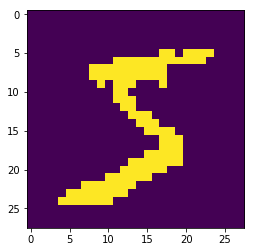

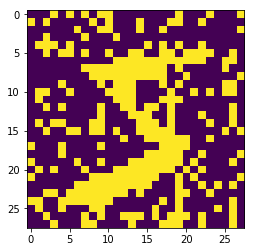

In [9]:
test_datapoint = x_train[0]
plt.imshow(test_datapoint.reshape(28,28))
plt.show()

rand_array = np.random.randint(0,2,(28,28,1))
rand_2 = np.random.randint(0,2,(28,28,1))
new = np.clip(test_datapoint + rand_array * rand_2,0,1)

plt.imshow(new.reshape(28,28))
plt.show()


In [10]:
train_size = x_train.shape[0]
test_size = x_test.shape[0]
crossover_rate = 0.35
mutation_rate = 0.25
population_size = 10
generations = 200

promo = 2

required_val = 5

initial_popl = np.array([new.reshape(28*28)] * population_size)
print(initial_popl.shape)

prev_popl = [[0,0]]
change = False

for gen in range(generations):
    change = False
    while(not change):
        data, fitness = genetic_op(initial_popl, required_val, crossover_rate, mutation_rate)
        data_with_fitness = zip(data,fitness)
        data_with_fitness = sorted(data_with_fitness, key=lambda x: x[1], reverse=True)

        #Now select the top 10% of the data for the next round
        promotion = data_with_fitness[:int(population_size/promo)]
#         print("Max fitness for gen {} is {}".format(gen,promotion[0][1]))
        if (prev_popl[0][1] > promotion[0][1]):
#             print("{} generation stays".format(saved_gen))
            initial_popl = np.array([x[0] for x in prev_popl])
        else:
            only_data = [x[0] for x in promotion]
            initial_popl = np.array(only_data * promo)
            prev_popl = promotion * promo
            saved_gen = gen
            change = True
    print("Max fitness for gen {} is {}".format(gen,promotion[0][1]))
    print([x[1] for x in promotion])

(10, 784)
Max fitness for gen 0 is 0.23667572438716888
[0.23667572, 0.095381223, 0.018761624, 0.015540553, 0.0014556809]
Max fitness for gen 1 is 0.3930527865886688
[0.39305279, 0.0041468344, 0.0029559049, 0.0016184167, 0.001163795]
Max fitness for gen 2 is 0.4033615291118622
[0.40336153, 0.15294306, 0.0021201125, 0.0015417457, 0.00046144545]
Max fitness for gen 3 is 0.8196965456008911
[0.81969655, 0.023258148, 0.021232037, 0.0032424137, 0.003054688]
Max fitness for gen 4 is 0.9772023558616638
[0.97720236, 0.11308028, 0.0036872462, 0.0023775061, 0.0008984374]
Max fitness for gen 5 is 0.9805888533592224
[0.98058885, 0.16026361, 0.0010414995, 0.00056151603, 0.00043864574]
Max fitness for gen 6 is 0.9952864050865173
[0.99528641, 0.048651531, 0.0041404641, 0.0035218613, 0.0032532224]


KeyboardInterrupt: 

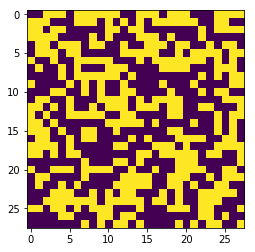

In [11]:
test_datapoint = prev_popl[0][0]
plt.imshow(test_datapoint.reshape(28,28))
plt.show()

In [12]:
testing = test_datapoint.reshape(1,28,28,1)
r = model.predict(testing)

print(r)

[[  1.13143372e-07   5.50182335e-08   1.29975160e-06   4.40019357e-05
    1.28951996e-08   9.95286405e-01   2.32305410e-06   3.20427398e-06
    4.65964898e-03   3.00656484e-06]]
